In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [8]:
fraud_data = pd.read_csv('../data/cleaned_data_1.csv')
credit_data = pd.read_csv('../data/cleaned_data_2.csv')

In [9]:
# Drop non-numeric columns that are not needed for model training
fraud_data = fraud_data.drop(["user_id", "device_id", "signup_time", "purchase_time"], axis=1)



In [10]:
# Define features and target variable
X = fraud_data.drop("class", axis=1)
y = fraud_data["class"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [11]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9581202736766294
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     25193
           1       1.00      0.55      0.71      2577

    accuracy                           0.96     27770
   macro avg       0.98      0.77      0.84     27770
weighted avg       0.96      0.96      0.95     27770



## Analyze Feature Importance

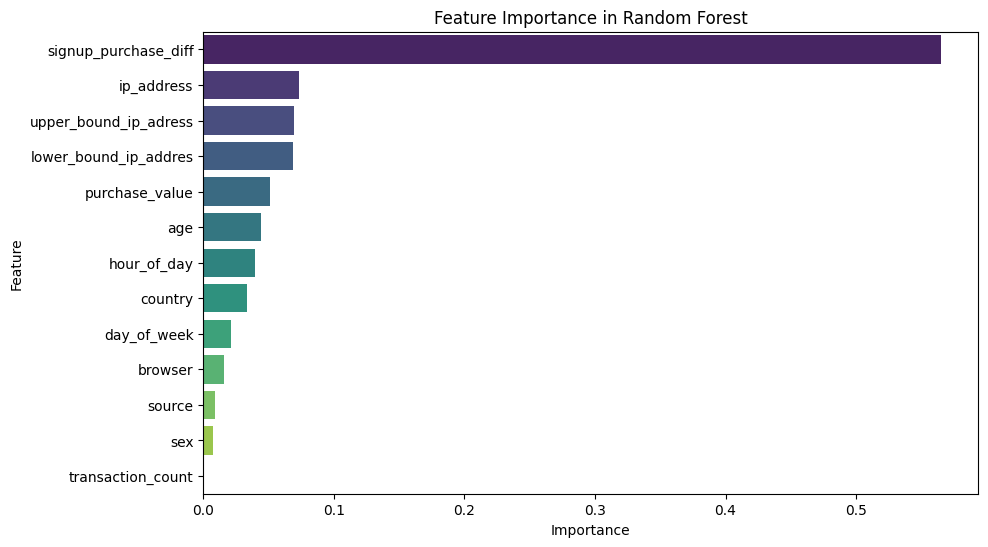

In [12]:
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort feature importances
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, hue="Feature", palette="viridis", legend=False)
plt.title("Feature Importance in Random Forest")
plt.show()


# Use SHAP for Model Explainability

In [13]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test[:100], check_additivity=False)




 99%|===================| 198/200 [00:20<00:00]        

In [27]:
X_test = pd.DataFrame(X_test, columns=X_train.columns)

In [28]:
print(type(shap_values))
print(shap_values.shape)  # Check if this is a 2D array (samples, features)


<class 'shap._explanation.Explanation'>
(100, 13, 2)


In [29]:
feature_index = X_test.columns.get_loc("purchase_value")


In [30]:
print(shap_values[:, feature_index, 0].shape)  # For class 0
print(shap_values[:, feature_index, 1].shape)  # For class 1


(100,)
(100,)


In [37]:
print(X_test.shape)


(27770, 13)


In [38]:
print(shap_values_class_0.shape)


(100,)


AssertionError: 'shap_values' and 'features' values must have the same number of rows!

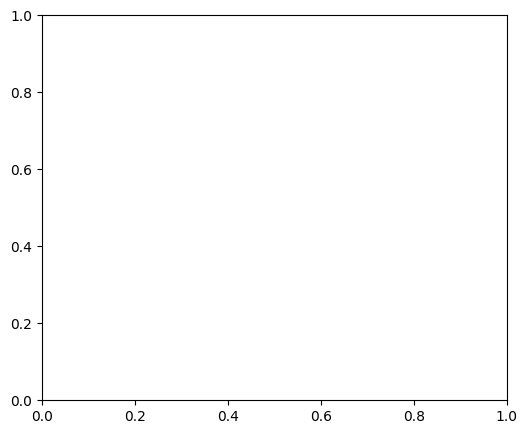

In [40]:
shap.dependence_plot(feature_index, shap_values_class_0, X_test, interaction_index=None)
plt.show()

ValueError: cannot reshape array of size 0 into shape (13,1)

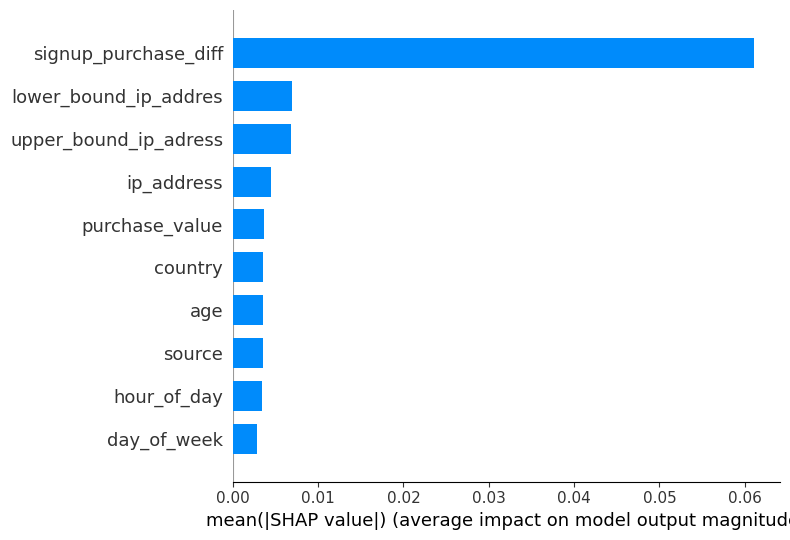

In [ ]:
# Summary Plot - Shows the importance and impact of each feature

shap_values_class_1 = shap_values[:, :, 1]  # Extract SHAP values for the second class (positive class)
shap.summary_plot(shap_values_class_1, X_test, plot_type="bar", max_display=10)


In [29]:
print(X_test.columns)


Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'ip_address',
       'country', 'lower_bound_ip_addres', 'upper_bound_ip_adress',
       'signup_purchase_diff', 'transaction_count', 'day_of_week',
       'hour_of_day'],
      dtype='object')


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])
